# Part 2: Deep Reinforcement Learning

In this part of the assignment you will work on a more challenging control task in the [Lunar Lander environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/). The state space is continuous and we will employ Deep Q-Learning (DQN) using a deep neural network to handle generalizing between states.

**Learning objectives.** You will:
1. Implement the Deep Q-learning (DQN) algorithm with epsilon greedy action selection
2. Apply DQN to train an agent on a challenging control task with a large (continuous) state space
3. Evaluate the learning curve of average episodic return over training

While it is possible to complete this assignment using CPU compute, it may be slow. To accelerate your training, consider using GPU resources such as `CUDA` through the CS department cluster. Alternatives include Google colab or local GPU resources for those running on machines with GPU support.

If you were able to run `pip install "gymnasium[all]"` in Part 1 then you may not need to install any additional dependencies to work with the Lunar Lander environment. However, if you were only able to install the base `gymnasium` then you may need to complete the additional installations of `swig` and `box2d` below. The first two commands use `pip` for the package manager, the third uses `conda` if you are using the Anaconda package manager.

In [1]:
!pip install swig

In [2]:
!pip install box2d-py

In [3]:
!conda install -c conda-forge swig box2d-py

/bin/bash: line 1: conda: command not found


You can check that the installation was successful by running the following code. The code attempts to import the gymnasium module, create a [Lunar Lander environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/), and then execute random actions in the environment.

The environment is set to `render_mode="human"`, meaning you should see a visualization of the environment with the agent taking random actions.

**Be aware that the visualization can be unstable on some platforms** -- in particular, it likely will not work on a remote server (CS cluster or Colab), and there is a possibility it will crash the Python Kernel when the visualization closes.

In [4]:
import gymnasium as gym

# Initialise the environment
env = gym.make("LunarLander-v3", render_mode="human")

# Reset the environment to generate the first observation
observation, info = env.reset()
for _ in range(200):
    # this is where you would insert your policy
    action = env.action_space.sample()

    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(action)

    # If the episode has ended then we can reset to start a new episode
    if terminated or truncated:
        observation, info = env.reset()

env.close()

## Task 1

As we will be implementing DQN, your first task is to define a deep neural network architecture to use to estimate the Q function during training. You should familiarize yourself with the [Lunar Lander environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/) documentation to understand the state/observation space, action space, and reward function.

**Key Environment Properties:**
- **State space:** 8-dimensional continuous vector containing position, velocity, angle, angular velocity, and leg contact information
- **Action space:** 4 discrete actions (do nothing, fire left engine, fire main engine, fire right engine)

**Network Architecture Recommendations:**
- **Input layer:** Should accept 8-dimensional state vectors
- **Hidden layers:** 2-3 fully connected layers with 128-256 neurons each work well. Use ReLU activation between layers.
- **Output layer:** Should output 4 Q-values (one for each action). No activation on output.

In [5]:
import torch
import torch.nn as nn

class NeuralNet(torch.nn.Module):
    """
    Implements a neural network representation of
    the Q-function for use in DQN.
    """
    def __init__(self):
        super(NeuralNet, self).__init__()
        # TODO: Implement constructor/initialization
        self.network = nn.Sequential(
            nn.Linear(8, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        """
        Input should represent state/observation space encoding
        Output should be a q-function estimate for each possible
        discrete action.
        """
        # TODO: Implement forward propagation
        return self.network(x)

## Task 2

Your next task is to define the `LunarLanderAgent` which should implement the deep Q-learning (DQN) algorithm following a similar structure of `__init__`, `action_select`, and `update` as in Part 1.

**Implementation Details and Tips.** The implementation will be more challenging than in the Part 1 tabular case.

1. **Two Networks:** Both networks share the same architecture but have separate parameters.
   - **Main Q-network:** Updated every step with gradient descent
   - **Target Q-network:** Frozen copy used for computing target values, periodically updated by copying weights from main network (every 1,000-5,000 steps is a good default)
   
2. **Update Step:** For each batch sampled from the replay buffer:
   - Compute Q-values for current states using main network. You can use `q_network(states).gather(1, actions)`.
      - If `q_values` has shape `(batch_size, 4)` (Q-values for all 4 actions), and `actions` has shape `(batch_size, 1)`, then `q_values.gather(1, actions)` selects the Q-value corresponding to the action that was actually taken, returning a tensor of shape `(batch_size, 1)`.
   - Compute target Q-values using target network. You can use `rewards + (1 - terminated) * discount * target_network(next_states).max(1)[0]`
      - `.max(1)` returns `(max_values, indices)` tuple finding the max along dimension 1 (across actions); `[0]` extracts just the max values
      - `(1 - terminated)` zeros out future rewards for terminated episodes
   - Use `torch.no_grad()` when computing targets to prevent gradient computation through the target network
   - Compute MSE loss between current Q-values and target Q-values, take a gradient descent step with the optimizer
   - **Important:** Pass only `terminated` (not `terminated or truncated`) as the done flag in your experience tuples. The `truncated` flag indicates a timeout, which means there is still future value to bootstrap from, so it should not zero out the future reward term.

4. **Hyperparameter Recommendations:** You may need to tweak the hyperparameters, but the following are reasonable starting ranges, and reasonable default values have been selected in the class skeleton.
   - Learning rate: 0.0005 - 0.001
   - Discount factor: 0.99
   - Epsilon decay: 0.995 - 0.999
   - Epsilon minimum: 0.01 - 0.02
   - Target network update frequency: 1000-5000 steps
   - Batch size: 32 - 128

**GPU Usage Tips:** While you are not required to use GPU training for Q-network operations, it will substantially accelerate training, and you are encouraged to do so. Make sure not to store all of the experiences in your entire experience replay buffer on the GPU.
- Move networks to device: `model.to(device)`
- Store replay buffer experiences on CPU (as Python tuples/NumPy arrays)
- Only move sampled batches to GPU when computing loss: `states.to(device)`

**Documentation links:**
- [`collections.deque`](https://docs.python.org/3/library/collections.html#collections.deque) - Efficient replay buffer
- [`random.sample()`](https://docs.python.org/3/library/random.html#random.sample) - Sample batch from buffer
- [`torch.gather()`](https://pytorch.org/docs/stable/generated/torch.gather.html) - Select Q-values for taken actions.
- [`tensor.max()`](https://pytorch.org/docs/stable/generated/torch.max.html) - Get maximum Q-values
- [`model.load_state_dict()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.load_state_dict) - Copy network weights

In [6]:
from random import sample
from collections import deque
import numpy as np
import torch
import torch.nn as nn

# Check for GPU availability (CUDA first, then MPS, then CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

class LunarLanderAgent:
    """
    Implements a deep Q-learning agent for the Lunar Lander environment.
    """
    def __init__(self, env, discount=0.99, learning_rate=0.001,
                 buffer_size=100000, batch_size=64, target_update_freq=1000,
                 epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.999):
        """
        Initialize the DQN agent.

        Args:
            discount: Discount factor (gamma)
            learning_rate: Learning rate for optimizer
            buffer_size: Maximum size of replay buffer
            batch_size: Number of transitions to sample per update
            target_update_freq: Steps between target network updates
            epsilon_start: Initial exploration rate
            epsilon_min: Minimum exploration rate
            epsilon_decay: Multiplicative decay for epsilon
        """
        self.env = env
        self.discount = discount
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # Initialize replay buffer
        self.replay_buffer = deque(maxlen=buffer_size)

        # TODO: Complete initialization of networks, loss, optimizer, etc.
        self.q_network = NeuralNet().to(device)
        self.target_network = NeuralNet().to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr = learning_rate)
        self.loss_function = nn.MSELoss()
        self.training_steps = 0

    def action_select(self, state):
        """
        Epsilon-greedy action selection using neural network.

        Args:
            state: NumPy array of shape (8,)

        Returns:
            action: Integer action (0-3)
        """
        # TODO: Implement epsilon-greedy action selection
        action = None
        if np.random.rand() < self.epsilon:
          action = self.env.action_space.sample()
          return action
        with torch.no_grad():
          x = torch.tensor(state, device = device).unsqueeze(0)
          q_vals = self.q_network(x)
          action = torch.argmax(q_vals, dim = 1).item()
        return action

    def update(self, state, action, reward, next_state, terminated):
        """
        Store experience and perform learning update if buffer is ready.

        Args:
            state: Current state
            action: Action taken
            reward: Reward received
            next_state: Next state
            terminated: Whether episode terminated
        """
        self.replay_buffer.append((state, action, reward, next_state, terminated))

        if len(self.replay_buffer) < self.batch_size:
            return

        batch = sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(np.array(states), dtype=torch.float).to(device)
        actions = torch.tensor(np.array(actions), dtype=torch.long).unsqueeze(1).to(device)
        rewards = torch.tensor(np.array(rewards), dtype=torch.float).unsqueeze(1).to(device)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float).to(device)
        terminations = torch.tensor(np.array(dones), dtype=torch.int).unsqueeze(1).to(device)

        # TODO: Implement DQN update step
        q_values = self.q_network(states).gather(1, actions)
        with torch.no_grad():
          target = rewards + (1 - terminations) * self.discount * self.target_network(next_states).max(1)[0].unsqueeze(1)
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        self.optimizer.zero_grad()
        loss = self.loss_function(q_values, target)
        loss.backward()
        self.optimizer.step()
        self.training_steps += 1
        if self.training_steps % self.target_update_freq == 0:
          self.target_network.load_state_dict(self.q_network.state_dict())

Using device: cuda


## Task 3
Train your DQN agent on the Lunar Lander environment. You can modify hyperparameters for the `LunarLanderAgent` or the number of episodes of training as needed, but the default values have been selected to be reasonable for this task. You are encouraged, but not required, to print the average return of every `print_every` episodes.

**What to Expect.** You should be able to learn a policy that achieves an average/expected episode return (cumulative reward) of approximately 200 -- **we will consider the training a success if the average/expected episode return converges to greater than 150**. To accomplish this you may need to experiment with several of the key hyperparameters for the learning agent. Note that the learning will likely be much more challenging and variable than in the Part 1 warmup task.

Training will take quite some time on this environment: You should expect to need between **1 and 10 thousand episodes** of experience (You should use a small number between 100 and 1 thousand while prototyping your implementation, then several thousand for your final training).

**GPU acceleration is advised** and even with GPU acceleration you should expect this to take **several minutes** (but not hours) for your final full training run.

Partially for this reason, you are strongly encourage to **save your Q-network model parameters** after a substantial and long training run, to ensure you do not lose them. See the [PyTorch documentation on loading and saving model parameters](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

**Environment Note and Timestep Penalty.** It is relatively common/likely on this lunar lander environment to get stuck in a local optimum where the agent learns to "hover" but not land. Landing correctly is difficult and crashing incurs a large negative reward, so sometimes the agent gets "stuck" in a policy of hovering in place without attempt to land. This results in an average return of around 0. If your agent is getting stuck like this, one recommendation is to modify the reward function by adding a per-timestep reward penalty during learning. A penalty of 0.2 is recommended, with a reminder to implement it in the training loop. You can adjust the value as needed.

In [7]:
def train(agent, env, n_episodes=1000, print_every=10, timestep_penalty=0.2):
    """
    Train a Q-learning agent.

    Args:
        agent: TaxiAgent instance to train
        env: Gymnasium environment (should be wrapped with RecordEpisodeStatistics)
        n_episodes: Number of episodes to train for
        print_every: Print progress every N episodes (set to None to disable printing)

    Returns:
        agent: The trained agent
        env: The environment with recorded statistics
    """
    for episode in range(n_episodes):
        state, info = env.reset()
        episode_over = False

        while not episode_over:
            # TODO: Implement training loop
            a = agent.action_select(state)
            s_new, r, terminated, truncated, info = env.step(a)
            r -= timestep_penalty
            agent.update(state, a, r, s_new, terminated)
            episode_over = terminated or truncated
            state = s_new

        #if print_every and (episode + 1) % print_every == 0:
            # TODO: Print average return over last print_every episodes

    return agent, env

In [8]:
# Initialise the environment
import gymnasium as gym
import numpy as np

# Can adjust n_episodes as needed
n_episodes = 600

env = gym.make("LunarLander-v3")
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

# Can adjust training hyperparameters of agent as needed
agent = LunarLanderAgent(env)

# Train the agent
agent, env = train(agent, env, n_episodes=n_episodes, print_every=20)

print(f"\nTraining complete!")
print(f"Final average return (last 100 episodes): {np.mean(list(env.return_queue)[-100:]):.2f}")


Training complete!
Final average return (last 100 episodes): 237.10


When you are finished training, you can use the `visualize_learning_curves` function defined below to create two plots:
- one of the moving average episode return over the course of training,
- and another of the moving average episode length over the course of training.

A `smoothing` parameter to the function determines how many episodes to average over. That is, the default of `smoothing=10` means that each point in the resulting figure is the average of ten episodes. This has the visual effect of *smoothing* out the appearance of the plot, which can make the overall trend easier to visualize even if individual episodes vary significantly.

Run to the next code  create visualizations of your learning curves. You should see improving performance on average episode return converging toward approximately zero.

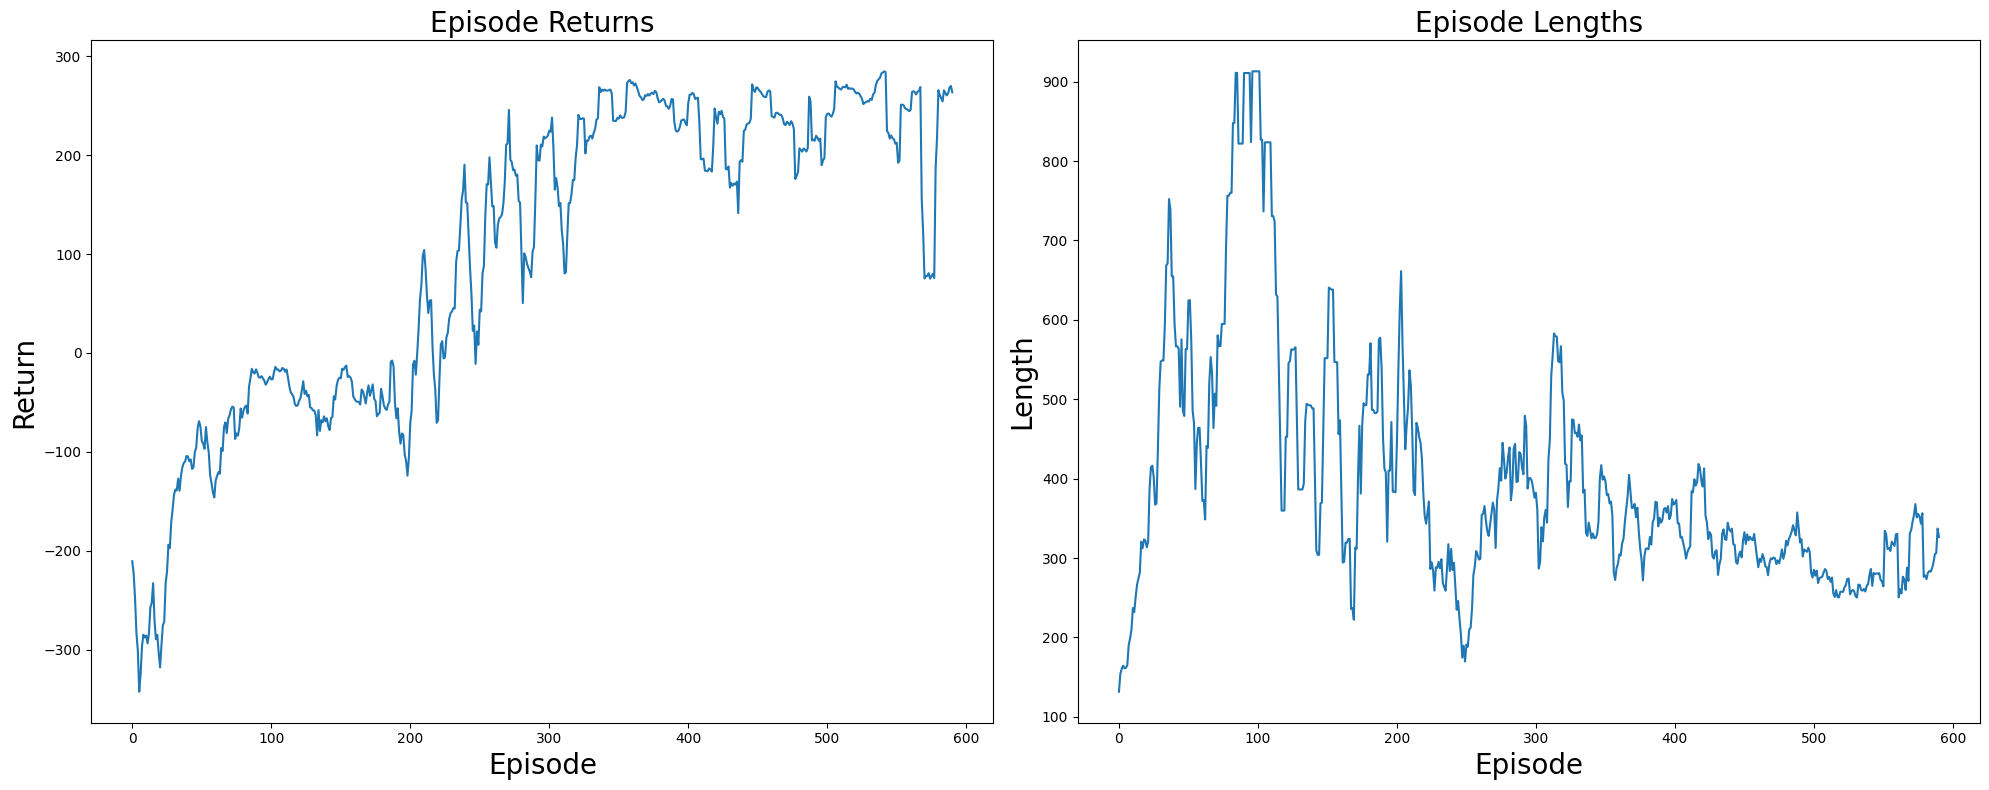

In [9]:
# Run, but you do not need to modify this code

import numpy as np
from matplotlib import pyplot as plt

def visualize_learning_curves(env, smoothing=10):
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))

    axs[0].plot(np.convolve(env.return_queue, np.ones(smoothing), 'valid') / smoothing)
    axs[0].set_title("Episode Returns", fontsize=20)
    axs[0].set_xlabel("Episode", fontsize=20)
    axs[0].set_ylabel("Return", fontsize=20)

    axs[1].plot(np.convolve(env.length_queue, np.ones(smoothing), 'valid') / smoothing)
    axs[1].set_title("Episode Lengths", fontsize=20)
    axs[1].set_xlabel("Episode", fontsize=20)
    axs[1].set_ylabel("Length", fontsize=20)

    plt.tight_layout()
    plt.show()

visualize_learning_curves(env, smoothing=10)

**Optional Qualitative Visualizaiton.** The above evaluation of the learning curve was purely quantiative. While you are not required, you are invited and encouraged to qualitatively evaluate your learned policy/agent visually below.

To do so:
1. Render the environment in `"human"` mode as shown below. This should render the visualization of the environment.
2. Write a standard environment loop over several episodes (but far fewer than used for training, perhaps just 5 or so), and use the trained agent for action selection.
3. For this evaluation purpose, you are welcome to set `epsilon` to a lower value or even 0, and you do not need to perform learning updates.

**Be aware that the visualization can be unstable on some platforms** - It is possible your Python Kernel will crash after closing the visualization. This part is optional and not required.

Note: The visualization likely will not render on a remote server (if you are running on OnDemand on the CS Cluster or on the Google Colab).

In [10]:
# optional todo: environment loop to visualize learned policy

# WARNING: DO NOT RUN THIS IF YOU HAVE NOT SAVED YOUR TRAINED
# MODEL AND DO NOT KNOW IF IT WILL CRASH YOUR PYTHON KERNEL,
# OR ELSE YOU MAY LOST THE RESULTS OF A LONG TRAINING RUN

# optionally uncomment and run the following for visualization
# env = gym.make("LunarLander-v3", render_mode="human")

## Task 4

Answer the following reflection and analysis questions.

**Question 1.** In the visualization of average episode length you will likely observe short initial episodes, followed by some very long episodes partway through training, and then episodes becoming short again as you approach convergence. Why is that expected in this environment? You may wish to review the [Lunar Lander environment documentation](https://gymnasium.farama.org/environments/box2d/lunar_lander/) in answering.

**TODO: Answer 1:** So at the start, the episodes are short most likely because the agent would act randomly and would probably crashed right away pretty often. With the visualization from task 3, I can see that the during the middle of training, the episodes would become longer as the agent would start learning to hover and explore more before landing. And also I can see that the episodes get shorter by the end since the agent learned to land safely and efficently which would finish each episode much faster.


**Question 2.** Why is the [Lunar Lander environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/) fundamentally not amenable to tabular Q-learning, or why is Deep Q-learning more appropriate for this task?

**TODO: Answer 2:** Well from the documentation, I find that the Lunar Lander environment has a continuous 8-dimensional state space such as the lander's position, velocity, angle, and leg contact. But the problem with tabular Q-learning is that it can only handle discrete states that can fit in a table. So deep Q-learning would be better in this case as it uses neural network to approximate the Q-values for continuous and high-dimensional states like what we have here.

